# Branch 3: 정규화 전략 비교 (TCN 스케일링 최적화)

## 🎯 분석 목적
Branch 2에서 선정된 TCN에 대한 스케일링 방법 비교

## 📊 실험 배경

### **Branch 2 결과**
```
1순위: XGBoost + RUL Clipping (RMSE: 16.23)
2순위: TCN + Both (RMSE: 20.01)
```

### **Branch 3 전략**

XGBoost는 스케일링의 영향을 받지 않으므로 TCN + Both만 진행

## 🔬 TCN 스케일링 실험

### **고정 조건**
- **모델**: TCN (window=30)
- **전처리**: Both (RUL ≤ 125 + Noise 제거)
- **센서**: 13개 (Signal 센서만)

### **변수: 스케일링 방법**
1. **StandardScaler** (Baseline): 평균 0, 표준편차 1
2. **MinMaxScaler**: 0~1 범위로 정규화
3. **RobustScaler**: 중앙값과 IQR 사용 (이상치 강건)

### **목표**
- Branch 2 결과(20.01)보다 개선
- 최적 스케일러 선정

In [ ]:
# Google Drive 마운트
from google.colab import drive
drive.mount('/content/drive')

print('✅ Google Drive 마운트 완료')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Google Drive 마운트 완료


In [ ]:
# 라이브러리 로드
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Input, Conv1D, GlobalAveragePooling1D, Dense, Dropout
from keras.callbacks import EarlyStopping

In [ ]:
# 한글 폰트 설정
import matplotlib.font_manager as fm

font_path = '/content/drive/MyDrive/ML project/NanumGothic-Regular.ttf'
font_prop = fm.FontProperties(fname=font_path)
fm.fontManager.addfont(font_path)

plt.rcParams['font.family'] = font_prop.get_name()
plt.rcParams['axes.unicode_minus'] = False

# 파일 경로 설정
DATA_PATH = '/content/drive/MyDrive/ML project'

# Branch 2 최적 전처리 (TCN)
RUL_THRESHOLD = 125
NOISE_SENSORS = ['s_1', 's_5', 's_8', 's_14', 's_15', 's_16', 's_18', 's_19']
WINDOW_SIZE = 30

In [ ]:
# 데이터 로드
train_original = pd.read_csv(f'{DATA_PATH}/train_df.csv')
test_original = pd.read_csv(f'{DATA_PATH}/test_df.csv')

# 센서 컬럼
SENSOR_COLS = [col for col in train_original.columns if col.startswith('s_')]
SIGNAL_SENSORS = [s for s in SENSOR_COLS if s not in NOISE_SENSORS]

In [ ]:
# 전처리 함수
def apply_preprocessing(data):
    data_processed = data.copy()
    data_processed['RUL'] = data_processed['RUL'].clip(upper=RUL_THRESHOLD)
    return data_processed

def create_sequences(data, sensors, window):
    X, y = [], []
    for unit in data['unit'].unique():
        unit_data = data[data['unit'] == unit].sort_values('cycle')
        values = unit_data[sensors].values
        targets = unit_data['RUL'].values

        for i in range(len(values) - window + 1):
            X.append(values[i:i+window])
            y.append(targets[i+window-1])

    return np.array(X), np.array(y)

# 전처리 적용 (Both)
train_processed = apply_preprocessing(train_original)
test_processed = apply_preprocessing(test_original)

---
## 실험: 3가지 스케일러 비교

In [ ]:
results = []
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [ ]:
# 1. StandardScaler (Baseline)
scaler = StandardScaler()
train_scaled = train_processed.copy()
test_scaled = test_processed.copy()

scaler.fit(train_processed[SIGNAL_SENSORS])
train_scaled[SIGNAL_SENSORS] = scaler.transform(train_processed[SIGNAL_SENSORS])
test_scaled[SIGNAL_SENSORS] = scaler.transform(test_processed[SIGNAL_SENSORS])

X_train, y_train = create_sequences(train_scaled, SIGNAL_SENSORS, WINDOW_SIZE)
X_test, y_test = create_sequences(test_scaled, SIGNAL_SENSORS, WINDOW_SIZE)

model_tcn = Sequential([
    Input(shape=(WINDOW_SIZE, len(SIGNAL_SENSORS))),
    Conv1D(64, kernel_size=3, padding='causal', activation='relu'),
    Dropout(0.2),
    Conv1D(32, kernel_size=3, padding='causal', activation='relu'),
    Dropout(0.2),
    GlobalAveragePooling1D(),
    Dense(16, activation='relu'),
    Dense(1)
])

model_tcn.compile(optimizer='adam', loss='mse')

history = model_tcn.fit(X_train, y_train, epochs=50, batch_size=512,
                       validation_split=0.2, callbacks=[early_stop], verbose=0)

y_pred_train = model_tcn.predict(X_train, verbose=0).flatten()
y_pred_test = model_tcn.predict(X_test, verbose=0).flatten()

train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
test_r2 = r2_score(y_test, y_pred_test)
overfit_gap = test_rmse - train_rmse

results.append({
    'scaler': 'StandardScaler',
    'train_rmse': train_rmse,
    'test_rmse': test_rmse,
    'test_r2': test_r2,
    'overfit_gap': overfit_gap,
    'improvement': 0.0,
    'total_epochs': len(history.history["loss"])
})

baseline_rmse = test_rmse

In [ ]:
# 2. MinMaxScaler
scaler = MinMaxScaler()
train_scaled = train_processed.copy()
test_scaled = test_processed.copy()

scaler.fit(train_processed[SIGNAL_SENSORS])
train_scaled[SIGNAL_SENSORS] = scaler.transform(train_processed[SIGNAL_SENSORS])
test_scaled[SIGNAL_SENSORS] = scaler.transform(test_processed[SIGNAL_SENSORS])

X_train, y_train = create_sequences(train_scaled, SIGNAL_SENSORS, WINDOW_SIZE)
X_test, y_test = create_sequences(test_scaled, SIGNAL_SENSORS, WINDOW_SIZE)

model_tcn = Sequential([
    Input(shape=(WINDOW_SIZE, len(SIGNAL_SENSORS))),
    Conv1D(64, kernel_size=3, padding='causal', activation='relu'),
    Dropout(0.2),
    Conv1D(32, kernel_size=3, padding='causal', activation='relu'),
    Dropout(0.2),
    GlobalAveragePooling1D(),
    Dense(16, activation='relu'),
    Dense(1)
])

model_tcn.compile(optimizer='adam', loss='mse')

history = model_tcn.fit(X_train, y_train, epochs=50, batch_size=512,
                       validation_split=0.2, callbacks=[early_stop], verbose=0)

y_pred_train = model_tcn.predict(X_train, verbose=0).flatten()
y_pred_test = model_tcn.predict(X_test, verbose=0).flatten()

train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
test_r2 = r2_score(y_test, y_pred_test)
overfit_gap = test_rmse - train_rmse
improvement = ((baseline_rmse - test_rmse) / baseline_rmse) * 100

results.append({
    'scaler': 'MinMaxScaler',
    'train_rmse': train_rmse,
    'test_rmse': test_rmse,
    'test_r2': test_r2,
    'overfit_gap': overfit_gap,
    'improvement': improvement,
    'total_epochs': len(history.history["loss"])
})

In [ ]:
# 3. RobustScaler
scaler = RobustScaler()
train_scaled = train_processed.copy()
test_scaled = test_processed.copy()

scaler.fit(train_processed[SIGNAL_SENSORS])
train_scaled[SIGNAL_SENSORS] = scaler.transform(train_processed[SIGNAL_SENSORS])
test_scaled[SIGNAL_SENSORS] = scaler.transform(test_processed[SIGNAL_SENSORS])

X_train, y_train = create_sequences(train_scaled, SIGNAL_SENSORS, WINDOW_SIZE)
X_test, y_test = create_sequences(test_scaled, SIGNAL_SENSORS, WINDOW_SIZE)

model_tcn = Sequential([
    Input(shape=(WINDOW_SIZE, len(SIGNAL_SENSORS))),
    Conv1D(64, kernel_size=3, padding='causal', activation='relu'),
    Dropout(0.2),
    Conv1D(32, kernel_size=3, padding='causal', activation='relu'),
    Dropout(0.2),
    GlobalAveragePooling1D(),
    Dense(16, activation='relu'),
    Dense(1)
])

model_tcn.compile(optimizer='adam', loss='mse')

history = model_tcn.fit(X_train, y_train, epochs=50, batch_size=512,
                       validation_split=0.2, callbacks=[early_stop], verbose=0)

y_pred_train = model_tcn.predict(X_train, verbose=0).flatten()
y_pred_test = model_tcn.predict(X_test, verbose=0).flatten()

train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
test_r2 = r2_score(y_test, y_pred_test)
overfit_gap = test_rmse - train_rmse
improvement = ((baseline_rmse - test_rmse) / baseline_rmse) * 100

results.append({
    'scaler': 'RobustScaler',
    'train_rmse': train_rmse,
    'test_rmse': test_rmse,
    'test_r2': test_r2,
    'overfit_gap': overfit_gap,
    'improvement': improvement,
    'total_epochs': len(history.history["loss"])
})


## 결과 분석

In [ ]:
# 결과 확인
df_results = pd.DataFrame(results)
df_results.to_csv(f'{DATA_PATH}/branch3_tcn_scaling_results.csv', index=False)
df_results

,scaler,train_rmse,test_rmse,test_r2,overfit_gap,improvement,total_epochs
0,StandardScaler,21.416071,20.195044,0.453312,-1.221027,0.000000,50
1,MinMaxScaler,24.401796,21.115682,0.402332,-3.286113,-4.558732,50
2,RobustScaler,21.794251,20.569334,0.432860,-1.224917,-1.853374,50


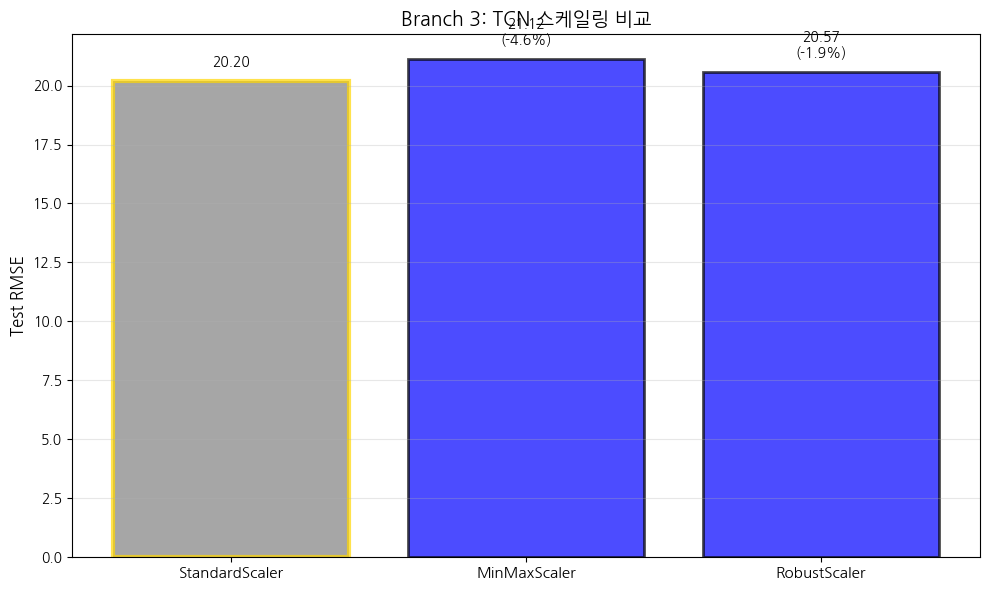

In [ ]:
# 시각화
fig, ax = plt.subplots(figsize=(10, 6))

# 최고 성능
best = df_results.loc[df_results['test_rmse'].idxmin()]

x = range(len(df_results))
colors = ['gray' if s == 'StandardScaler' else 'green' if s == best['scaler'] else 'blue'
         for s in df_results['scaler']]

bars = ax.bar(x, df_results['test_rmse'], color=colors, alpha=0.7,
             edgecolor='black', linewidth=2)

best_idx = df_results['test_rmse'].idxmin()
bars[best_idx].set_linewidth(3)
bars[best_idx].set_edgecolor('gold')

ax.set_xticks(x)
ax.set_xticklabels(df_results['scaler'], fontsize=11, fontweight='bold')
ax.set_ylabel('Test RMSE', fontsize=12, fontweight='bold')
ax.set_title('Branch 3: TCN 스케일링 비교', fontsize=14, fontweight='bold')
ax.grid(alpha=0.3, axis='y')

for bar, val, imp in zip(bars, df_results['test_rmse'], df_results['improvement']):
    label = f'{val:.2f}\n({imp:+.1f}%)' if imp != 0 else f'{val:.2f}'
    ax.text(bar.get_x() + bar.get_width()/2, val + 0.5,
           label, ha='center', va='bottom',
           fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()